In [6]:
pwd

'/home/qq/autoctr/notebook'

In [1]:
import sys
sys.path.append('../gen-py')

import numpy as np
from graphviz import Digraph
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import json
from models.builder import build_model
import os

from thrift.protocol import TSimpleJSONProtocol
from thrift.util import Serializer
from config import ttypes as config
jfactory = TSimpleJSONProtocol.TSimpleJSONProtocolFactory()

In [8]:
def gen_graph(model_id, meta, dir, verbose = True, dataset="criteo_search"):
    model =  meta[-model_id]
    dot = Digraph(comment='Graph' + str(model[1]), format='png')
    if verbose:
        print('model:', '_'.join(model[0]))
        print('fbl_id:', 'f' + str(model[1]))
    with dot.subgraph() as s:
        s.attr(rank='same')
        s.node('0_d', 'Dense', color='red')
        s.node('0_s', 'Sparse', color='red')

    name = 'M_' + model[-2][-4] + '_S_' + model[-2][-1] + '.json'
    
    print(dir+name)
    with open(dir+name) as fp:
        model_config_dict = json.load(fp)

    # rebuild model to get the final block config and the cleaned feature id
    input_summary = json.load(open("/home/qq/autoctr/utils/fblearner_template/"+dataset+".json"))
    
    feature_config = Serializer.deserialize(
                jfactory,
                json.dumps(input_summary["feature_options"]),
                config.FeatureConfig(),
            )
    model_config = Serializer.deserialize(
        jfactory,
        json.dumps(model_config_dict),
        config.ModelConfig(),
    )
    nasrec_model = build_model(model_config, feature_config)


    block_name = []
    for i, block in enumerate(nasrec_model.blocks):
        block_name.append(block.__str__()+'Block')
#         block_name.append(block.__str__()[:-6]+'Block')
        # dot.node(str(i+1), str(i+1) + '_' + block_name[-1], shape='box', style='filled', color='lightblue', fontcolor='white')
        dot.node(str(i+1), str(i+1) + '_' + block_name[-1], shape='box', color='green')

        dense = block.feat_dense_id
        sparse = block.feat_sparse_id
        skip_block_id = set(dense.keys()).union(set(sparse.keys()))
        cross_dense = []
        cross_sparse = []
        if block_name[-1] == "CrossNet(1, 1)":
            cross_dense = block.cross_feat_dense_id
            cross_sparse = block.cross_feat_sparse_id
            skip_block_id = skip_block_id.union(set(cross_dense.keys()))
            skip_block_id = skip_block_id.union(set(cross_sparse.keys()))

        for id in skip_block_id:
            if id == 0:
                if id in dense or (cross_dense and id in cross_dense):
                    dot.edge('0_d', str(i+1))
                if id in sparse or (cross_sparse and id in cross_sparse):
                    dot.edge('0_s', str(i+1))
            else:
                dot.edge(str(id), str(i+1))
            
    if verbose:
        return dot
    else:
        return dot, ['_'.join(model[0]), 'f' + str(model[1])]

In [9]:
def gen_mul_graphs(ids, meta, rewards, dir):
    names = []
    model_ids = []
    vals = []
    fbl_infos = []
    for model_id in ids:
        dot, fbl_info = gen_graph(model_id, meta, dir, verbose=False)
        fbl_infos.append(fbl_info)
        model_ids.append(len(meta) - model_id + 2)
        vals.append(rewards[-model_id]) 
        names.append('graphs/'+str(len(meta) - model_id + 2))
        dot.render(names[-1])
        del dot
    return names, model_ids, vals, fbl_infos

In [10]:
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        image=mpimg.imread(image + ".png")
        plt.imshow(image)
        title[0] = 'Model ID:' + str(title[0])
        title[1] = 'LogLoss:' + str(title[1])
        a.set_title(title, fontsize=100)
        plt.axis("off")
    fig.set_size_inches(np.array(fig.get_size_inches()*7) * n_images)
    plt.show()

### Random Criteo

total_model: 100
total_model: 100
min rewards: 0.49652692675590515
model_id: 21
val_logloss: 0.49652692675590515
model: [exp autoctr] nasnet_model_search_random_macro_space_type_2_21_updated_model_16
fbl_id: f21
../results/random/criteo/20200925-100520/M_21_S_16.json


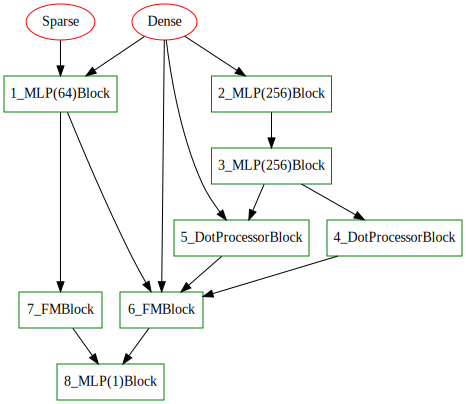

In [11]:
dir = '../results/random/criteo/20200925-100520/'

meta = np.load(dir+'fbl_meta.npy', allow_pickle=True)[:1500]
rewards = np.load(dir+'rewards.npy', allow_pickle=True)[:1500]
ind = np.argsort(rewards)
total_model = len(rewards)
print('total_model:', len(meta))
print('total_model:', len(rewards))
print('min rewards:', np.min(rewards))


model_id = total_model - np.argsort(rewards)[0]
print('model_id:', len(meta) - model_id)
print('val_logloss:', rewards[-model_id])
dot = gen_graph(model_id, meta, dir, dataset="criteo_search")
dot

### AutoCTR Criteo

total_model: 100
total_model: 100
min rewards: 0.4924725890159607
model_id: 73
val_logloss: 0.4924725890159607
model: [exp autoctr] nasnet_model_search_evo_macro_space_type_2_74_updated_model_73
fbl_id: f74
../results/evo/criteo/20200925-173209/M_74_S_73.json


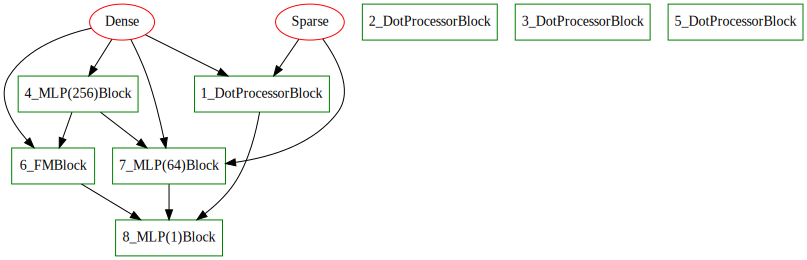

In [12]:
dir = '../results/evo/criteo/20200925-173209/'

meta = np.load(dir+'fbl_meta.npy', allow_pickle=True)[:1500]
rewards = np.load(dir+'rewards.npy', allow_pickle=True)[:1500]
ind = np.argsort(rewards)
total_model = len(rewards)
print('total_model:', len(meta))
print('total_model:', len(rewards))
print('min rewards:', np.min(rewards))


model_id = total_model - np.argsort(rewards)[0]
print('model_id:', len(meta) - model_id)
print('val_logloss:', rewards[-model_id])
dot = gen_graph(model_id, meta, dir, dataset="criteo_search")
dot